In [5]:
from sklearn.metrics import make_scorer, mean_squared_error, r2_score, mean_absolute_error, max_error
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from sklearn.preprocessing import PowerTransformer
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import LinearRegression,LogisticRegression
from sklearn.svm import SVR
from sklearn.ensemble import GradientBoostingRegressor
import matplotlib.pyplot as plt
from getdata import GetDataset
from typing import Union
import visuals as vs
import pandas as pd
import numpy as np
import seaborn as sns

Obtención del dataset

In [6]:
data,target = GetDataset(CreateDataFrame=True).Outputdata()

Cambio a base lineal y equisdistante

In [7]:
x = np.linspace(data[0][0].min(),data[0][0].max(),data.shape[2])
data_lin = np.zeros((data.shape[0],data.shape[2]))
for i in range(data.shape[0]):
    data_lin[i,:] = np.interp(x,data[i][0],data[i][1])

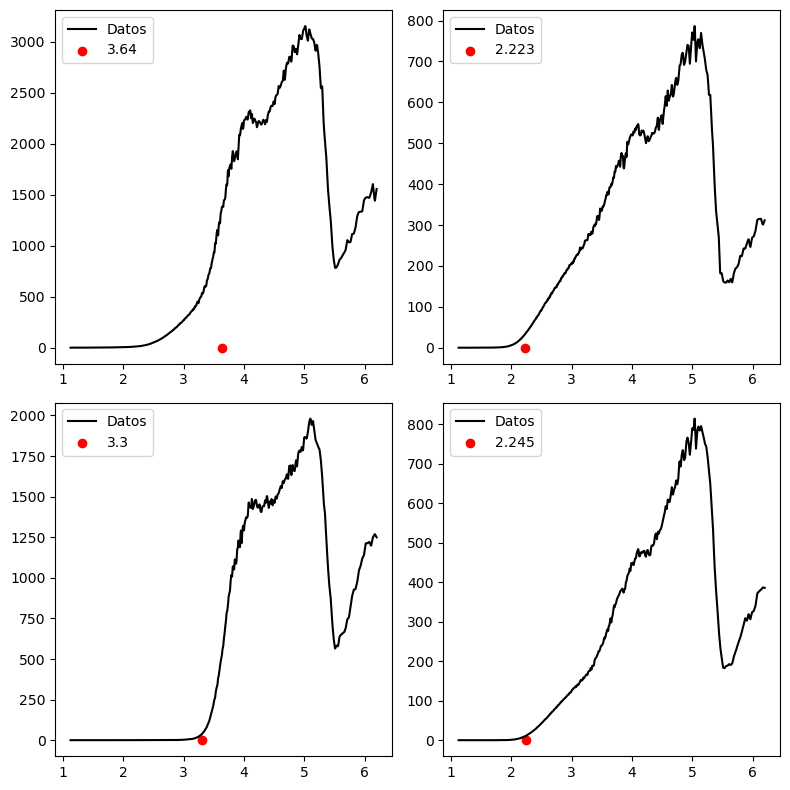

In [8]:
ids = np.random.randint(0, data_lin.shape[0], size=4)
fig,ax = plt.subplots(2,2,figsize=(8,8))

for i,id in enumerate(ids):
    ax[i//2,i%2].plot(x,data_lin[id],color='black')
    ax[i//2,i%2].scatter(target[id],y=0,color='red')
    ax[i//2,i%2].legend(["Datos",target[id].astype('str')])
plt.tight_layout()
plt.show()

Scorer


In [9]:
MSE_scorer = make_scorer(mean_squared_error,greater_is_better=False)

Extracción de caracteristicas

In [10]:
def TranformData(data):
    datatrans = np.zeros((data.shape[0],12))
    for i,element in enumerate(data):
        # 1. Valor máximo de la curva
        valor_maximo = np.max(element)
        # 2. Área bajo la curva (usando la regla del trapecio)
        area_bajo_curva = np.trapz(element)

        # 3. Tiempo de subida
        tiempo_de_subida = np.argmax(element)

        # 4. Tiempo de decaimiento
        tiempo_de_decaimiento = len(element) - tiempo_de_subida

        # 5. Tiempo medio de vida
        tiempo_medio_vida = (tiempo_de_subida + tiempo_de_decaimiento) / 2

        # 6. Pendiente máxima
        pendiente_maxima = np.max(np.gradient(element))

        # 7. Pendiente mínima
        pendiente_minima = np.min(np.gradient(element))

        # 8. Pendiente promedio
        pendiente_promedio = np.mean(np.gradient(element))


        # 9. Valor medio
        valor_medio = np.mean(element)

        # 10. Desviación estándar
        desviacion_estandar = np.std(element)

        # 11. Asimetría
        asimetria = np.mean((element - valor_medio) ** 3) / (np.std(element) ** 3)

        # 12. Curtosis
        curtosis = np.mean((element - valor_medio) ** 4) / (np.std(element) ** 4)

        dat = np.array([valor_maximo,area_bajo_curva,tiempo_de_subida,tiempo_de_decaimiento,tiempo_medio_vida,pendiente_maxima,pendiente_minima,pendiente_promedio,valor_medio,desviacion_estandar,asimetria,curtosis]).reshape(1,12)
        datatrans[i,:] = dat[:]
    columns = ['Valor_Maximo','ABC','Timp_Subida','Timp_Bajada','Timp_Med','Pendiente_Max','Pendiente_Min','Pendiente_Med','Valor_Medio','Desv_est','Asimetria','Curtosis']
    datat = pd.DataFrame(datatrans,columns=columns)
    return datat

new_data_frame = TranformData(data_lin)
new_data_array = np.array(new_data_frame)

Normalización de datos y división del dataset

In [11]:
min_data = MinMaxScaler().fit_transform(new_data_array)
stand_data = StandardScaler().fit_transform(new_data_array)
robs_data = RobustScaler().fit_transform(new_data_array)
pt_data_min = PowerTransformer(method='yeo-johnson').fit_transform(min_data)
pt_data_std = PowerTransformer(method='yeo-johnson').fit_transform(stand_data)
pt_data_robs = PowerTransformer(method='yeo-johnson').fit_transform(robs_data)
X_train_min, X_test_min, y_train_min, y_test_min = train_test_split(pt_data_min, target, test_size=0.2, random_state=42, shuffle=True)
X_train_std, X_test_std, y_train_std, y_test_std = train_test_split(pt_data_std, target, test_size=0.2, random_state=42, shuffle=True)
X_train_robs, X_test_robs, y_train_robs, y_test_robs = train_test_split(pt_data_robs, target, test_size=0.2, random_state=42, shuffle=True)

Reducción de dimensionalidad PCA

MinMaxScaler

In [12]:
pca_min = PCA()
X_train_pca_min = pca_min.fit_transform(X_train_min)
X_test_pca_min = pca_min.transform(X_test_min)

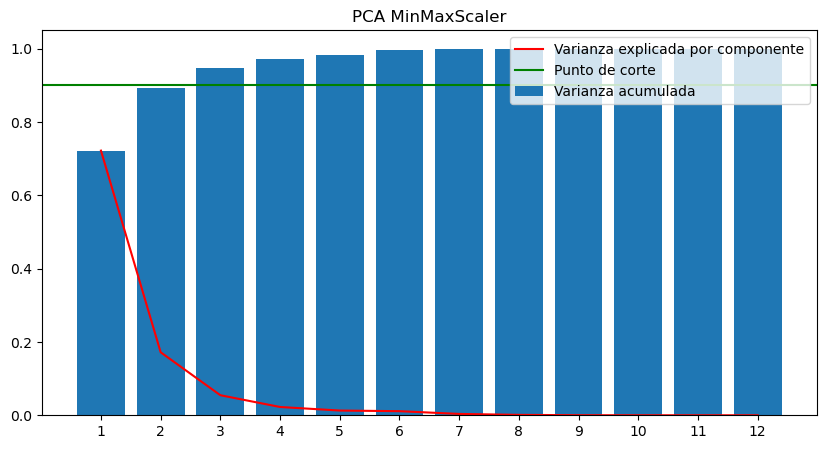

In [13]:
plt.figure(figsize=(10,5))
plt.plot(range(1,pca_min.explained_variance_ratio_.shape[0]+1),pca_min.explained_variance_ratio_, c='red', label='Varianza explicada por componente')
plt.bar(range(1,pca_min.explained_variance_ratio_.shape[0]+1), height=np.cumsum(pca_min.explained_variance_ratio_), label='Varianza acumulada')
plt.axhline(y=0.9, c='g', label='Punto de corte')
plt.title('PCA MinMaxScaler')
plt.xticks(range(1,pca_min.explained_variance_ratio_.shape[0]+1))
plt.legend(loc=1)
plt.show()

,Explained Variance,Valor_Maximo,ABC,Timp_Subida,Timp_Bajada,Timp_Med,Pendiente_Max,Pendiente_Min,Pendiente_Med,Valor_Medio,Desv_est,Asimetria,Curtosis
Dimension 1,0.7218,0.3378,0.3482,-0.2424,0.2404,0.0,0.3242,-0.3256,0.2561,0.3482,0.3439,-0.2434,-0.2695
Dimension 2,0.1718,-0.1859,-0.0831,-0.4695,0.4710,-0.0,-0.2124,0.1841,-0.4075,-0.0834,-0.1444,-0.3878,-0.3050


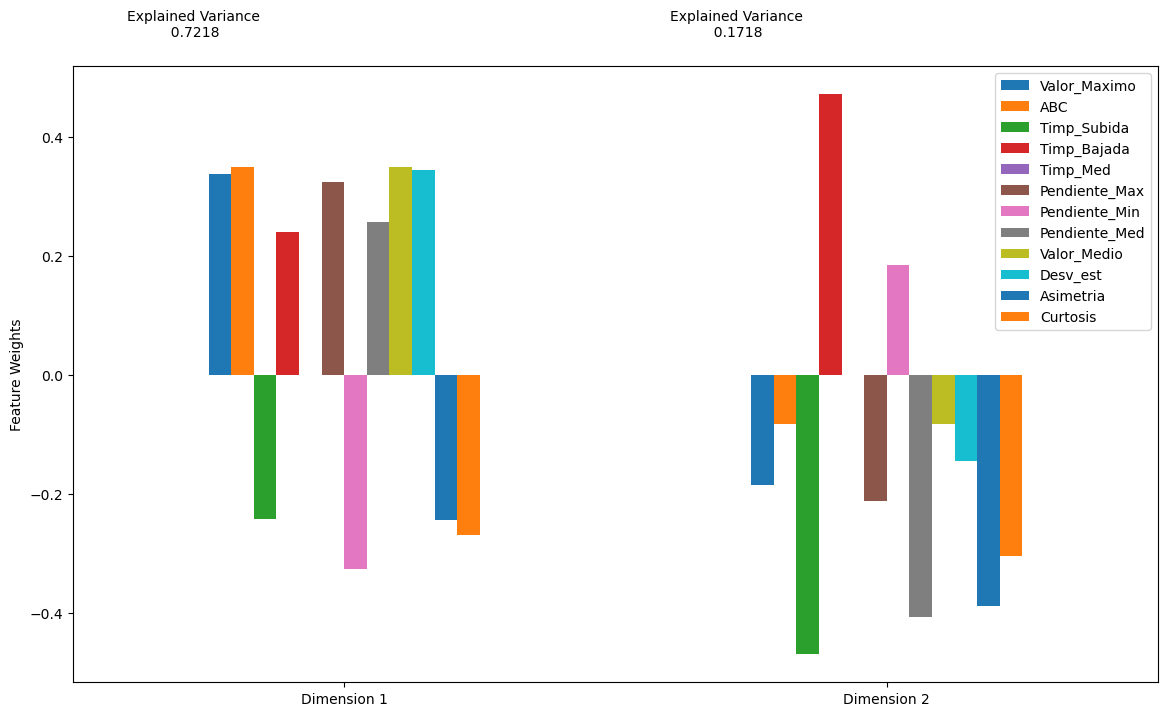

In [14]:
vs.pca_results(pd.DataFrame(X_train_pca_min,columns=new_data_frame.columns),pca_min,2)

StandarScaler

In [15]:
pca_std = PCA()
X_train_pca_std = pca_std.fit_transform(X_train_std)
X_test_pca_std = pca_std.transform(X_test_std)

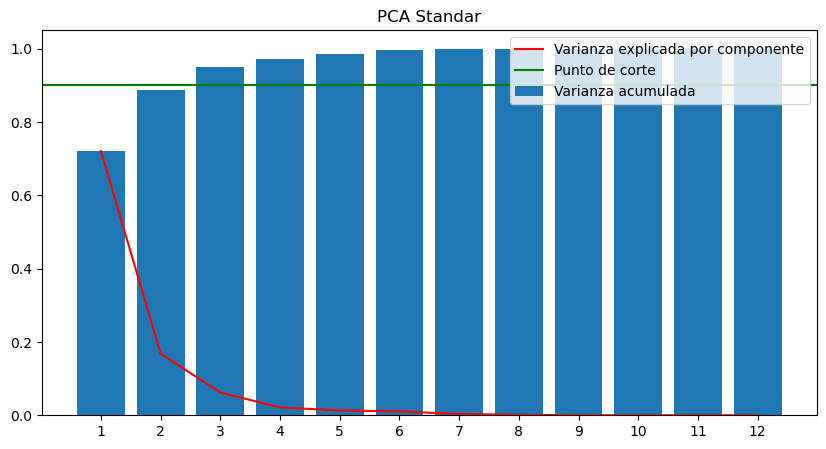

In [16]:
plt.figure(figsize=(10,5))
plt.plot(range(1,pca_std.explained_variance_ratio_.shape[0]+1),pca_std.explained_variance_ratio_, c='red', label='Varianza explicada por componente')
plt.bar(range(1,pca_std.explained_variance_ratio_.shape[0]+1), height=np.cumsum(pca_std.explained_variance_ratio_), label='Varianza acumulada')
plt.axhline(y=0.9, c='g', label='Punto de corte')
plt.title('PCA Standar')
plt.xticks(range(1,pca_std.explained_variance_ratio_.shape[0]+1))
plt.legend(loc=1)
plt.show()

,Explained Variance,Valor_Maximo,ABC,Timp_Subida,Timp_Bajada,Timp_Med,Pendiente_Max,Pendiente_Min,Pendiente_Med,Valor_Medio,Desv_est,Asimetria,Curtosis
Dimension 1,0.7203,0.3386,0.3482,-0.2349,0.2349,0.0,0.3280,-0.3307,0.2598,0.3482,0.3444,-0.2382,-0.2696
Dimension 2,0.1677,-0.1845,-0.0862,-0.4968,0.4968,-0.0,-0.1924,0.1542,-0.4094,-0.0865,-0.1475,-0.3639,-0.2735


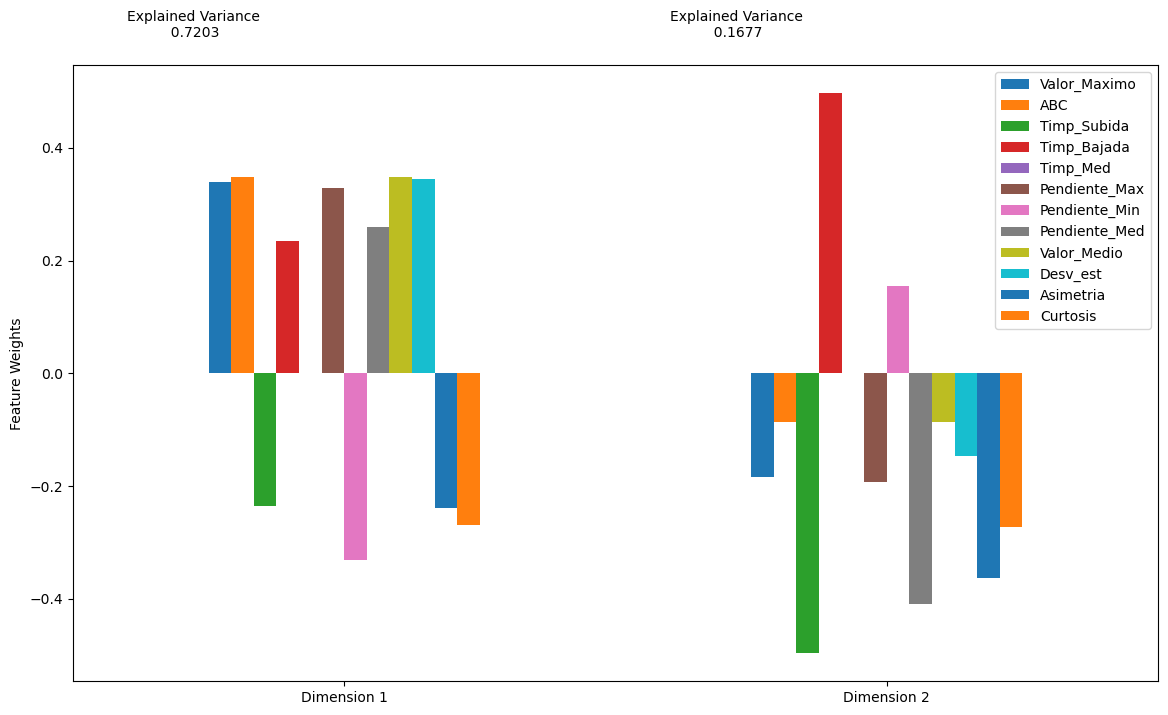

In [17]:
vs.pca_results(pd.DataFrame(X_train_pca_std,columns=new_data_frame.columns),pca_std,2)

RobustScaler

In [18]:
pca_rob = PCA()
X_train_pca_rob = pca_rob.fit_transform(X_train_robs)
X_test_pca_rob = pca_rob.transform(X_test_robs)

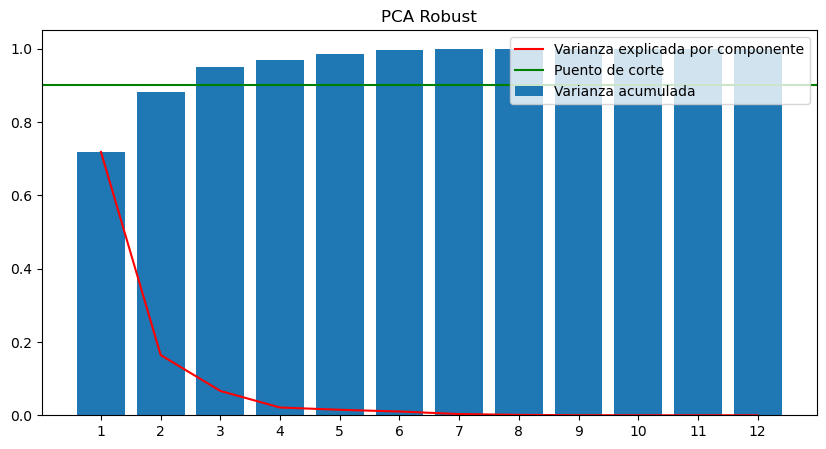

In [19]:
plt.figure(figsize=(10,5))
plt.plot(range(1,pca_rob.explained_variance_ratio_.shape[0]+1),pca_rob.explained_variance_ratio_, c='red', label='Varianza explicada por componente')
plt.bar(range(1,pca_rob.explained_variance_ratio_.shape[0]+1), height=np.cumsum(pca_rob.explained_variance_ratio_), label='Varianza acumulada')
plt.axhline(y=0.9, c='g', label='Puento de corte')
plt.title('PCA Robust')
plt.xticks(range(1,pca_rob.explained_variance_ratio_.shape[0]+1))
plt.legend(loc=1)
plt.show()

,Explained Variance,Valor_Maximo,ABC,Timp_Subida,Timp_Bajada,Timp_Med,Pendiente_Max,Pendiente_Min,Pendiente_Med,Valor_Medio,Desv_est,Asimetria,Curtosis
Dimension 1,0.7182,0.3390,0.3486,-0.2352,0.2352,0.0,0.3322,-0.3334,0.2572,0.3486,0.3450,-0.2331,-0.2652
Dimension 2,0.1644,-0.1875,-0.0866,-0.5008,0.5008,-0.0,-0.1781,0.1325,-0.4251,-0.0868,-0.1485,-0.3599,-0.2582


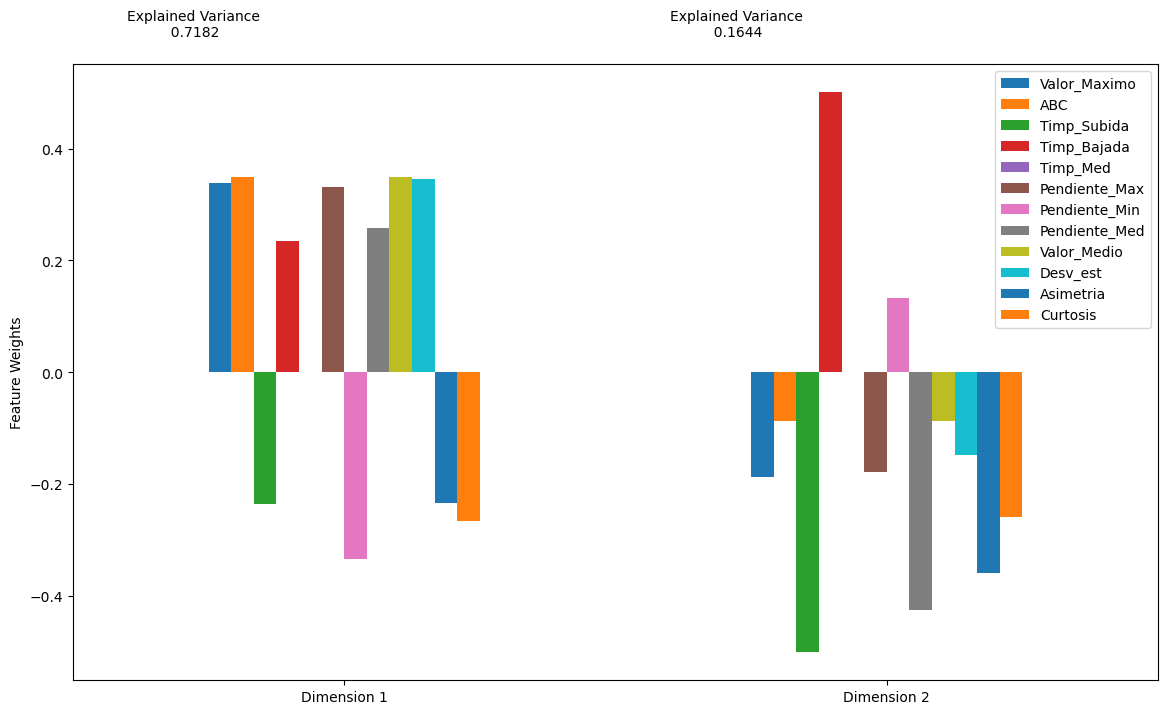

In [20]:
vs.pca_results(pd.DataFrame(X_train_pca_rob,columns=new_data_frame.columns),pca_rob,2)

Busqueda de parametros

In [21]:
def Results(data:list,view:str)->pd.DataFrame:
    Metrics = pd.DataFrame(data,columns=[view,'MSE','RMSE','MAE','R2','Max_Error'])
    metrics_name = []
    metrics_value = []
    for column in Metrics.columns[1:]:
        if column == 'R2':
            val_sorted = Metrics[column].sort_values(ascending=False)
            indices_originales = pd.Series(val_sorted.index, index=val_sorted.values)
            metrics_value.append(pd.DataFrame(np.array(val_sorted),index=None,columns=[column]))
            metrics_name.append(pd.DataFrame(np.array(Metrics.iloc[indices_originales,0]),index=None,columns=[column]))

        else:
            val_sorted = Metrics[column].sort_values(ascending=True)
            indices_originales = pd.Series(val_sorted.index, index=val_sorted.values)
            metrics_value.append(pd.DataFrame(np.array(val_sorted),index=None,columns=[column]))
            metrics_name.append(pd.DataFrame(np.array(Metrics.iloc[indices_originales,0]),index=None,columns=[column]))
    Metrics_values = pd.concat(metrics_value,axis=1)
    Metrics_name = pd.concat(metrics_name,axis=1)

    df_combined = pd.DataFrame()
    for column in Metrics_name.columns:
        # Concatenamos los valores de las columnas de ambos DataFrames, con los valores de Metrics_name entre paréntesis
        df_combined[column] = Metrics_name[column] + ' (' + round(Metrics_values[column],3).astype(str) + ')'

    # Muestra el DataFrame combinado
    return df_combined

In [22]:
def ParamsSearch(model,
                 X:np.ndarray,
                 y:np.ndarray,
                 params:dict,
                 scoring:Union[np.ndarray,list,tuple]=MSE_scorer,
                 n_iters:int=200) -> dict:
    grid_search = RandomizedSearchCV(model, params, cv=5, scoring=scoring,n_jobs=-1,n_iter=n_iters)
    grid_search.fit(X, y)
    return grid_search.best_params_

In [23]:
"""
Example:

model_DT = DecisionTreeRegressor(min_samples_split=5,min_samples_leaf=7,max_depth=10) 
params = {    'max_depth': [None, 5, 10, 20,30,40],
    'min_samples_split': [2, 5, 6,810],
    'min_samples_leaf': [1, 2, 4,6,8],
    'max_features': [None, 'sqrt', 'log2'],
    'random_state': [0,42,123]}

p = ParamsSearch(model_DT,X_train_pca_min,y_train_min,params,MSE_scorer,800)
print(p)
"""

"\nExample:\n\nmodel_DT = DecisionTreeRegressor(min_samples_split=5,min_samples_leaf=7,max_depth=10) \nparams = {    'max_depth': [None, 5, 10, 20,30,40],\n    'min_samples_split': [2, 5, 6,810],\n    'min_samples_leaf': [1, 2, 4,6,8],\n    'max_features': [None, 'sqrt', 'log2'],\n    'random_state': [0,42,123]}\n\np = ParamsSearch(model_DT,X_train_pca_min,y_train_min,params,MSE_scorer,800)\nprint(p)\n"

Regresión lineal

In [25]:
model_linear = LinearRegression(fit_intercept=True,copy_X=True,n_jobs=-1,positive=False) 
y_pred = model_linear.fit(X_train_pca_min, y_train_min).predict(X_test_pca_min)
data_model_LN_min = {'Normalizacion': 'MMScaler',
              'MSE': mean_squared_error(y_pred=y_pred,y_true=y_test_min),
              'RMSE': np.sqrt(mean_squared_error(y_pred=y_pred,y_true=y_test_min)),
              'MAE': mean_absolute_error(y_pred=y_pred,y_true=y_test_min),
              'R2': r2_score(y_pred=y_pred,y_true=y_test_min),
              'Max_Error': max_error(y_pred=y_pred,y_true=y_test_min)}
print("MAE:", mean_absolute_error(y_pred=y_pred,y_true=y_test_min))
print("MSE:",mean_squared_error(y_pred=y_pred,y_true=y_test_min))
print("RMSE:",np.sqrt(mean_squared_error(y_pred=y_pred,y_true=y_test_min)))
print("R2:",r2_score(y_pred=y_pred,y_true=y_test_min))
print("Max_Error:",max_error(y_pred=y_pred,y_true=y_test_min))

MAE: 0.4154851321220682
MSE: 0.293945042768014
RMSE: 0.5421669878994976
R2: 0.34468136314836206
Max_Error: 2.422096371280786


In [26]:
model_linear = LinearRegression(fit_intercept=True,copy_X=True,n_jobs=-1,positive=False) #0.391
y_pred = model_linear.fit(X_train_pca_std, y_train_std).predict(X_test_pca_std)
data_model_LN_std = {'Normalizacion': 'StadScaler',
              'MSE': mean_squared_error(y_pred=y_pred,y_true=y_test_std),
              'RMSE': np.sqrt(mean_squared_error(y_pred=y_pred,y_true=y_test_std)),
              'MAE': mean_absolute_error(y_pred=y_pred,y_true=y_test_std),
              'R2': r2_score(y_pred=y_pred,y_true=y_test_std),
              'Max_Error': max_error(y_pred=y_pred,y_true=y_test_std)}
print("MAE:", mean_absolute_error(y_pred=y_pred,y_true=y_test_std))
print("MSE:",mean_squared_error(y_pred=y_pred,y_true=y_test_std))
print("RMSE:",np.sqrt(mean_squared_error(y_pred=y_pred,y_true=y_test_std)))
print("R2:",r2_score(y_pred=y_pred,y_true=y_test_std))
print("Max_Error:",max_error(y_pred=y_pred,y_true=y_test_std))

MAE: 0.4147597195013527
MSE: 0.2899136311103095
RMSE: 0.5384362832409323
R2: 0.35366895881330984
Max_Error: 2.3659528106997603


In [27]:
model_linear = LinearRegression(fit_intercept=True,copy_X=True,n_jobs=-1,positive=False) #0.391
y_pred = model_linear.fit(X_train_pca_rob, y_train_robs).predict(X_test_pca_rob)

data_model_LN_rob = {'Normalizacion': 'RobScaler',
              'MSE': mean_squared_error(y_pred=y_pred,y_true=y_test_robs),
              'RMSE': np.sqrt(mean_squared_error(y_pred=y_pred,y_true=y_test_robs)),
              'MAE': mean_absolute_error(y_pred=y_pred,y_true=y_test_robs),
              'R2': r2_score(y_pred=y_pred,y_true=y_test_robs),
              'Max_Error': max_error(y_pred=y_pred,y_true=y_test_robs)}
print("MAE:", mean_absolute_error(y_pred=y_pred,y_true=y_test_robs))
print("MSE:",mean_squared_error(y_pred=y_pred,y_true=y_test_robs))
print("RMSE:",np.sqrt(mean_squared_error(y_pred=y_pred,y_true=y_test_robs)))
print("R2:",r2_score(y_pred=y_pred,y_true=y_test_robs))
print("Max_Error:",max_error(y_pred=y_pred,y_true=y_test_robs))

MAE: 0.41313363792289254
MSE: 0.28354792844100374
RMSE: 0.5324921862722529
R2: 0.3678606034709969
Max_Error: 2.246879792946726


Mejor normalización para regresión lineal

In [28]:
Results([data_model_LN_min,data_model_LN_std,data_model_LN_rob],'Normalizacion')

,MSE,RMSE,MAE,R2,Max_Error
0,RobScaler (0.284),RobScaler (0.532),RobScaler (0.413),RobScaler (0.368),RobScaler (2.247)
1,StadScaler (0.29),StadScaler (0.538),StadScaler (0.415),StadScaler (0.354),StadScaler (2.366)
2,MMScaler (0.294),MMScaler (0.542),MMScaler (0.415),MMScaler (0.345),MMScaler (2.422)


In [42]:
model_linear = LinearRegression(fit_intercept=True,copy_X=True,n_jobs=-1,positive=False) #0.391
y_pred = model_linear.fit(X_train_pca_std, y_train_std).predict(X_test_pca_std)

data_model_LN = {'Model': 'LinearRegression',
              'MSE': mean_squared_error(y_pred=y_pred,y_true=y_test_std),
              'RMSE': np.sqrt(mean_squared_error(y_pred=y_pred,y_true=y_test_std)),
              'MAE': mean_absolute_error(y_pred=y_pred,y_true=y_test_std),
              'R2': r2_score(y_pred=y_pred,y_true=y_test_std),
              'Max_Error': max_error(y_pred=y_pred,y_true=y_test_std)}


print("MAE:", mean_absolute_error(y_pred=y_pred,y_true=y_test_std))
print("MSE:",mean_squared_error(y_pred=y_pred,y_true=y_test_std))
print("RMSE:",np.sqrt(mean_squared_error(y_pred=y_pred,y_true=y_test_std)))
print("R2:",r2_score(y_pred=y_pred,y_true=y_test_std))
print("Max_Error:",max_error(y_pred=y_pred,y_true=y_test_std))

MAE: 0.4147597195013527
MSE: 0.2899136311103095
RMSE: 0.5384362832409323
R2: 0.35366895881330984
Max_Error: 2.3659528106997603


Arbol de decisión

In [30]:
model_DT = DecisionTreeRegressor(min_samples_split=2,min_samples_leaf=10,max_depth=10,random_state=42) 
y_pred = model_DT.fit(X_train_pca_min, y_train_min).predict(X_test_pca_min)
data_model_DT_min = {'Normalizacion': 'MMScaler',
              'MSE': mean_squared_error(y_pred=y_pred,y_true=y_test_min),
              'RMSE': np.sqrt(mean_squared_error(y_pred=y_pred,y_true=y_test_min)),
              'MAE': mean_absolute_error(y_pred=y_pred,y_true=y_test_min),
              'R2': r2_score(y_pred=y_pred,y_true=y_test_min),
              'Max_Error': max_error(y_pred=y_pred,y_true=y_test_min)}
print("MAE:", mean_absolute_error(y_pred=y_pred,y_true=y_test_min))
print("MSE:",mean_squared_error(y_pred=y_pred,y_true=y_test_min))
print("RMSE:",np.sqrt(mean_squared_error(y_pred=y_pred,y_true=y_test_min)))
print("R2:",r2_score(y_pred=y_pred,y_true=y_test_min))
print("Max_Error:",max_error(y_pred=y_pred,y_true=y_test_min))

MAE: 0.3153237395344157
MSE: 0.22968629578371696
RMSE: 0.47925598147933113
R2: 0.487939279944658
Max_Error: 3.1275333333333326


In [31]:
model_DT = DecisionTreeRegressor(min_samples_split=2,min_samples_leaf=8,max_depth=10,max_features='sqrt',random_state=42) 
y_pred = model_DT.fit(X_train_pca_std, y_train_std).predict(X_test_pca_std)
data_model_DT_std = {'Normalizacion': 'StadScaler',
              'MSE': mean_squared_error(y_pred=y_pred,y_true=y_test_std),
              'RMSE': np.sqrt(mean_squared_error(y_pred=y_pred,y_true=y_test_std)),
              'MAE': mean_absolute_error(y_pred=y_pred,y_true=y_test_std),
              'R2': r2_score(y_pred=y_pred,y_true=y_test_std),
              'Max_Error': max_error(y_pred=y_pred,y_true=y_test_std)}
print("MAE:", mean_absolute_error(y_pred=y_pred,y_true=y_test_std))
print("MSE:",mean_squared_error(y_pred=y_pred,y_true=y_test_std))
print("RMSE:",np.sqrt(mean_squared_error(y_pred=y_pred,y_true=y_test_std)))
print("R2:",r2_score(y_pred=y_pred,y_true=y_test_std))
print("Max_Error:",max_error(y_pred=y_pred,y_true=y_test_std))



MAE: 0.3336328312873831
MSE: 0.22390148401225524
RMSE: 0.4731822946943971
R2: 0.5008358912595474
Max_Error: 1.9187500000000002


In [32]:
model_DT = DecisionTreeRegressor(min_samples_split=2, min_samples_leaf=20,random_state=42) 
y_pred = model_DT.fit(X_train_pca_rob, y_train_robs).predict(X_test_pca_rob)
data_model_DT = {'Normalizacion': 'RobScaler',
              'MSE': mean_squared_error(y_pred=y_pred,y_true=y_test_robs),
              'RMSE': np.sqrt(mean_squared_error(y_pred=y_pred,y_true=y_test_robs)),
              'MAE': mean_absolute_error(y_pred=y_pred,y_true=y_test_robs),
              'R2': r2_score(y_pred=y_pred,y_true=y_test_robs),
              'Max_Error': max_error(y_pred=y_pred,y_true=y_test_robs)}
print("MAE:", mean_absolute_error(y_pred=y_pred,y_true=y_test_robs))
print("MSE:",mean_squared_error(y_pred=y_pred,y_true=y_test_robs))
print("RMSE:",np.sqrt(mean_squared_error(y_pred=y_pred,y_true=y_test_robs)))
print("R2:",r2_score(y_pred=y_pred,y_true=y_test_robs))
print("Max_Error:",max_error(y_pred=y_pred,y_true=y_test_robs))

MAE: 0.3477911589081608
MSE: 0.2528372770995193
RMSE: 0.5028292723176717
R2: 0.43632667449030194
Max_Error: 2.2252187500000002


Mejor normalización para arbol de decisiones

In [33]:
Results([data_model_DT_min,data_model_DT_std,data_model_DT_rob],'Normalizacion')

,MSE,RMSE,MAE,R2,Max_Error
0,StadScaler (0.224),StadScaler (0.473),MMScaler (0.315),StadScaler (0.501),StadScaler (1.919)
1,MMScaler (0.23),MMScaler (0.479),StadScaler (0.334),MMScaler (0.488),RobScaler (2.225)
2,RobScaler (0.253),RobScaler (0.503),RobScaler (0.348),RobScaler (0.436),MMScaler (3.128)


In [47]:
model_DT = DecisionTreeRegressor(min_samples_split=2,min_samples_leaf=8,max_depth=10,max_features='sqrt',random_state=42) 
y_pred = model_DT.fit(X_train_pca_std, y_train_std).predict(X_test_pca_std)
data_model_DT = {'Model': 'DecisionTree',
              'MSE': mean_squared_error(y_pred=y_pred,y_true=y_test_std),
              'RMSE': np.sqrt(mean_squared_error(y_pred=y_pred,y_true=y_test_std)),
              'MAE': mean_absolute_error(y_pred=y_pred,y_true=y_test_std),
              'R2': r2_score(y_pred=y_pred,y_true=y_test_std),
              'Max_Error': max_error(y_pred=y_pred,y_true=y_test_std)}
print("MAE:", mean_absolute_error(y_pred=y_pred,y_true=y_test_std))
print("MSE:",mean_squared_error(y_pred=y_pred,y_true=y_test_std))
print("RMSE:",np.sqrt(mean_squared_error(y_pred=y_pred,y_true=y_test_std)))
print("R2:",r2_score(y_pred=y_pred,y_true=y_test_std))
print("Max_Error:",max_error(y_pred=y_pred,y_true=y_test_std))

MAE: 0.3336328312873831
MSE: 0.22390148401225524
RMSE: 0.4731822946943971
R2: 0.5008358912595474
Max_Error: 1.9187500000000002


In [41]:
model_RF = RandomForestRegressor(n_estimators=300,max_features='sqrt',min_samples_split=2,min_samples_leaf=1,random_state=42)
y_pred = model_DT.fit(X_train_pca_min, y_train_min).predict(X_test_pca_min)
data_model_RF_min = {'Normalizacion': 'MMScaler',
              'MSE': mean_squared_error(y_pred=y_pred,y_true=y_test_min),
              'RMSE': np.sqrt(mean_squared_error(y_pred=y_pred,y_true=y_test_min)),
              'MAE': mean_absolute_error(y_pred=y_pred,y_true=y_test_min),
              'R2': r2_score(y_pred=y_pred,y_true=y_test_min),
              'Max_Error': max_error(y_pred=y_pred,y_true=y_test_min)}
print("MAE:", mean_absolute_error(y_pred=y_pred,y_true=y_test_min))
print("MSE:",mean_squared_error(y_pred=y_pred,y_true=y_test_min))
print("RMSE:",np.sqrt(mean_squared_error(y_pred=y_pred,y_true=y_test_min)))
print("R2:",r2_score(y_pred=y_pred,y_true=y_test_min))
print("Max_Error:",max_error(y_pred=y_pred,y_true=y_test_min))



MAE: 0.3381625984509762
MSE: 0.23018856531325924
RMSE: 0.4797797049826714
R2: 0.48681952442732646
Max_Error: 2.314925925925927


In [35]:
model_RF = RandomForestRegressor(n_estimators=300,min_samples_split=2,min_samples_leaf=1,max_features='sqrt',max_depth=30,random_state=42)
y_pred = model_DT.fit(X_train_pca_std, y_train_std).predict(X_test_pca_std)
data_model_RF_std = {'Normalizacion': 'StadScaler',
              'MSE': mean_squared_error(y_pred=y_pred,y_true=y_test_std),
              'RMSE': np.sqrt(mean_squared_error(y_pred=y_pred,y_true=y_test_std)),
              'MAE': mean_absolute_error(y_pred=y_pred,y_true=y_test_std),
              'R2': r2_score(y_pred=y_pred,y_true=y_test_std),
              'Max_Error': max_error(y_pred=y_pred,y_true=y_test_std)}
print("MAE:", mean_absolute_error(y_pred=y_pred,y_true=y_test_std))
print("MSE:",mean_squared_error(y_pred=y_pred,y_true=y_test_std))
print("RMSE:",np.sqrt(mean_squared_error(y_pred=y_pred,y_true=y_test_std)))
print("R2:",r2_score(y_pred=y_pred,y_true=y_test_std))
print("Max_Error:",max_error(y_pred=y_pred,y_true=y_test_std))

MAE: 0.3381625984509762
MSE: 0.23018856531325924
RMSE: 0.4797797049826714
R2: 0.48681952442732646
Max_Error: 2.314925925925927


In [36]:
model_RF = RandomForestRegressor(n_estimators=300,min_samples_split=2,min_samples_leaf=1,max_features='sqrt',max_depth=30)
y_pred = model_DT.fit(X_train_pca_rob, y_train_robs).predict(X_test_pca_rob)
data_model_RF_rob = {'Normalizacion': 'RobScaler',
              'MSE': mean_squared_error(y_pred=y_pred,y_true=y_test_robs),
              'RMSE': np.sqrt(mean_squared_error(y_pred=y_pred,y_true=y_test_robs)),
              'MAE': mean_absolute_error(y_pred=y_pred,y_true=y_test_robs),
              'R2': r2_score(y_pred=y_pred,y_true=y_test_robs),
              'Max_Error': max_error(y_pred=y_pred,y_true=y_test_robs)}
print("MAE:", mean_absolute_error(y_pred=y_pred,y_true=y_test_robs))
print("MSE:",mean_squared_error(y_pred=y_pred,y_true=y_test_robs))
print("RMSE:",np.sqrt(mean_squared_error(y_pred=y_pred,y_true=y_test_robs)))
print("R2:",r2_score(y_pred=y_pred,y_true=y_test_robs))
print("Max_Error:",max_error(y_pred=y_pred,y_true=y_test_robs))

MAE: 0.3477911589081608
MSE: 0.2528372770995193
RMSE: 0.5028292723176717
R2: 0.43632667449030194
Max_Error: 2.2252187500000002


In [37]:
Results([data_model_RF_min,data_model_RF_std,data_model_RF_rob],'Normalizacion')

,MSE,RMSE,MAE,R2,Max_Error
0,MMScaler (0.229),MMScaler (0.479),StadScaler (0.338),MMScaler (0.488),RobScaler (2.225)
1,StadScaler (0.23),StadScaler (0.48),MMScaler (0.342),StadScaler (0.487),MMScaler (2.248)
2,RobScaler (0.253),RobScaler (0.503),RobScaler (0.348),RobScaler (0.436),StadScaler (2.315)


In [49]:
model_RF = RandomForestRegressor(n_estimators=300,min_samples_split=2,min_samples_leaf=1,max_features='sqrt',max_depth=30,random_state=42)
y_pred = model_RF.fit(X_train_pca_std, y_train_std).predict(X_test_pca_std)
data_model_RF = {'Model': 'RandomForest',
              'MSE': mean_squared_error(y_pred=y_pred,y_true=y_test_std),
              'RMSE': np.sqrt(mean_squared_error(y_pred=y_pred,y_true=y_test_std)),
              'MAE': mean_absolute_error(y_pred=y_pred,y_true=y_test_std),
              'R2': r2_score(y_pred=y_pred,y_true=y_test_std),
              'Max_Error': max_error(y_pred=y_pred,y_true=y_test_std)}


print("MAE:", mean_absolute_error(y_pred=y_pred,y_true=y_test_std))
print("MSE:",mean_squared_error(y_pred=y_pred,y_true=y_test_std))
print("RMSE:",np.sqrt(mean_squared_error(y_pred=y_pred,y_true=y_test_std)))
print("R2:",r2_score(y_pred=y_pred,y_true=y_test_std))
print("Max_Error:",max_error(y_pred=y_pred,y_true=y_test_std))

MAE: 0.29370882487622024
MSE: 0.15681999641849084
RMSE: 0.3960050459507945
R2: 0.6503868025250232
Max_Error: 1.7689600000000105


In [50]:
Results([data_model_DT,data_model_LN,data_model_RF],'Model')

,MSE,RMSE,MAE,R2,Max_Error
0,RandomForest (0.157),RandomForest (0.396),RandomForest (0.294),RandomForest (0.65),RandomForest (1.769)
1,DecisionTree (0.224),DecisionTree (0.473),DecisionTree (0.334),DecisionTree (0.501),DecisionTree (1.919)
2,LinearRegression (0.29),LinearRegression (0.538),LinearRegression (0.415),LinearRegression (0.354),LinearRegression (2.366)
